<a href="https://colab.research.google.com/github/nerobite/neural_networks/blob/main/%D0%9A%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D0%B5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from PIL import Image

class BaseDataProvider(object):
    channels = 1
    n_class = 2

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(np.bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3


    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):


    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=bool)
    mask = np.zeros((nx, ny), dtype=bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1

    if rectangles:
        mask = np.zeros((nx, ny), dtype=bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            m = np.zeros((nx, ny), dtype=bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h

        label[mask, 2] = 1

        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)

    if rectangles:
        return image, label
    else:
        return image, label[..., 1]




def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
nx = 572
ny = 572

In [4]:
generator = GrayScaleDataProvider(nx, ny, cnt=20)

In [5]:
x_test, y_test = generator(1)

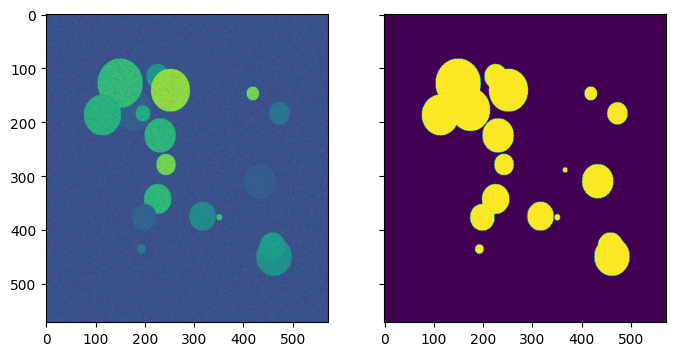

In [6]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

In [7]:
y_test[0,...,1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.center = CBR(512, 1024)
        self.dec4 = CBR(1024 + 512, 512)
        self.dec3 = CBR(512 + 256, 256)
        self.dec2 = CBR(256 + 128, 128)
        self.dec1 = CBR(128 + 64, 64)
        self.final = nn.Conv2d(64, 1, kernel_size=1)

        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        center = self.center(self.pool(enc4))

        dec4 = self.dec4(torch.cat([self._upsample(center, enc4.size()), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self._upsample(dec4, enc3.size()), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self._upsample(dec3, enc2.size()), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self._upsample(dec2, enc1.size()), enc1], dim=1))

        return torch.sigmoid(self.final(dec1))

    def _upsample(self, x, size):
        return F.interpolate(x, size=size[2:], mode='bilinear', align_corners=True)

# Инициализация модели
model = UNet()

In [9]:
nx = 572
ny = 572
generator = GrayScaleDataProvider(nx, ny, cnt=20)

# Генерация тренировочных данных
x_train, y_train = generator(10)

In [10]:
# Преобразование данных в тензоры PyTorch
x_train = torch.from_numpy(x_train).permute(0, 3, 1, 2).float()  # Меняем местами оси
y_train = torch.from_numpy(y_train).permute(0, 3, 1, 2).float()  # Меняем местами оси

In [11]:
# Убедимся, что целевые метки имеют один канал
y_train = y_train[:, 1:2, :, :]

In [12]:
# Функция потерь и оптимизатор
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for i in range(len(x_train)):
        inputs = x_train[i].unsqueeze(0)  # Добавляем размер batch
        labels = y_train[i].unsqueeze(0)  # Добавляем размер batch

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(x_train)}')

# Сохранение модели
torch.save(model.state_dict(), 'unet.pth')

Epoch 1/10, Loss: 0.9002699613571167
Epoch 2/10, Loss: 0.6743607640266418
Epoch 3/10, Loss: 0.48562088906764983
Epoch 4/10, Loss: 0.44981700032949445
Epoch 5/10, Loss: 0.6055145591497422
Epoch 6/10, Loss: 0.30502931624650953
Epoch 7/10, Loss: 0.2389671817421913
Epoch 8/10, Loss: 0.22755084037780762
Epoch 9/10, Loss: 0.2042522497475147
Epoch 10/10, Loss: 0.089877849817276


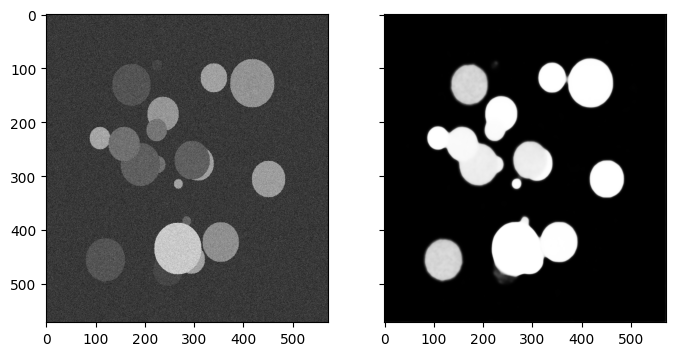

In [14]:
# Генерация тестовых данных
x_test, y_test = generator(1)
x_test = torch.from_numpy(x_test).permute(0, 3, 1, 2).float()  # Меняем местами оси
y_test = torch.from_numpy(y_test).permute(0, 3, 1, 2).float()  # Меняем местами оси

model.load_state_dict(torch.load('unet.pth'))
model.eval()

with torch.no_grad():
    inputs = x_test[0].unsqueeze(0)  # Добавляем размер batch
    output = model(inputs)
    output = output.squeeze().numpy()

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
ax[0].imshow(x_test[0, 0, :, :], aspect="auto", cmap='gray')
ax[1].imshow(output, aspect="auto", cmap='gray')
plt.show()